In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
df = pd.read_csv("data/obesity_data.csv")
df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


# Tiền xử lý dữ liệu

## Xóa cột id

In [3]:
df_clean = df.drop(columns=['id'])

## Chuẩn hóa tuổi, chiều cao và cân nặng

In [4]:
# Chuẩn hóa tuổi, chiều cao và cân nặng
# Làm tròn tuổi xuống
df_clean['Age'] = np.floor(df['Age'])

# Làm tròn chiều cao và cân nặng đến 2 chữ số thập phân
df_clean['Height'] = np.round(df['Height'], 2)
df_clean['Weight'] = np.round(df['Weight'], 2)

## Biến đổi các dữ liệu dạng Category sang dạng số

In [5]:
# Mã hóa CAEC và CALC theo thứ tự tăng dần
caec_mapping = {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}
calc_mapping = {'no': 0, 'Sometimes': 1, 'Frequently': 2}

df_clean['CAEC'] = df['CAEC'].map(caec_mapping)
df_clean['CALC'] = df['CALC'].map(calc_mapping)

print("Mapping CAEC:")
for key, value in sorted(caec_mapping.items(), key=lambda x: x[1]):
    print(f"  {key} -> {value}")

print("\nMapping CALC:")
for key, value in sorted(calc_mapping.items(), key=lambda x: x[1]):
    print(f"  {key} -> {value}")

# One-Hot Encoding cho MTRANS với giá trị 0/1
mtrans_dummies = pd.get_dummies(df['MTRANS'], prefix='MTRANS', dtype=int)
df_clean = pd.concat([df_clean, mtrans_dummies], axis=1)

df_clean = df_clean.drop('MTRANS', axis=1)

print("\nOne-Hot Encoding MTRANS:")
print(f"  Các cột mới: {list(mtrans_dummies.columns)}")

Mapping CAEC:
  no -> 0
  Sometimes -> 1
  Frequently -> 2
  Always -> 3

Mapping CALC:
  no -> 0
  Sometimes -> 1
  Frequently -> 2

One-Hot Encoding MTRANS:
  Các cột mới: ['MTRANS_Automobile', 'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation', 'MTRANS_Walking']


## Chuẩn hóa các dữ liệu dạng nhị phân, category hoặc onehot coding

In [6]:
# Chuẩn hóa các biến nhị phân (yes/no) thành 0/1
binary_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']

for col in binary_cols:
    if col == 'Gender':
        df_clean[col] = df[col].map({'Female': 0, 'Male': 1})
    else:
        df_clean[col] = df[col].map({'no': 0, 'yes': 1})

print("\nGiá trị unique trong mỗi cột:")
for col in binary_cols:
    print(f"{col}: {sorted(df_clean[col].unique())}")


Giá trị unique trong mỗi cột:
Gender: [np.int64(0), np.int64(1)]
family_history_with_overweight: [np.int64(0), np.int64(1)]
FAVC: [np.int64(0), np.int64(1)]
SMOKE: [np.int64(0), np.int64(1)]
SCC: [np.int64(0), np.int64(1)]


## Chuẩn hóa nhãn

In [7]:
# Chuẩn hóa nhãn (NObeyesdad)
label_encoder_target = LabelEncoder()
df_clean['NObeyesdad'] = label_encoder_target.fit_transform(df['NObeyesdad'])

print("Mapping của nhãn:")
for i, label in enumerate(label_encoder_target.classes_):
    print(f"{label} -> {i}")
    
print(f"\nSố lượng mẫu cho mỗi nhãn:")
print(df_clean['NObeyesdad'].value_counts().sort_index())

Mapping của nhãn:
Insufficient_Weight -> 0
Normal_Weight -> 1
Obesity_Type_I -> 2
Obesity_Type_II -> 3
Obesity_Type_III -> 4
Overweight_Level_I -> 5
Overweight_Level_II -> 6

Số lượng mẫu cho mỗi nhãn:
NObeyesdad
0    2523
1    3082
2    2910
3    3248
4    4046
5    2427
6    2522
Name: count, dtype: int64


# Trực quan hóa dữ liệu

## Tỷ lệ nhãn

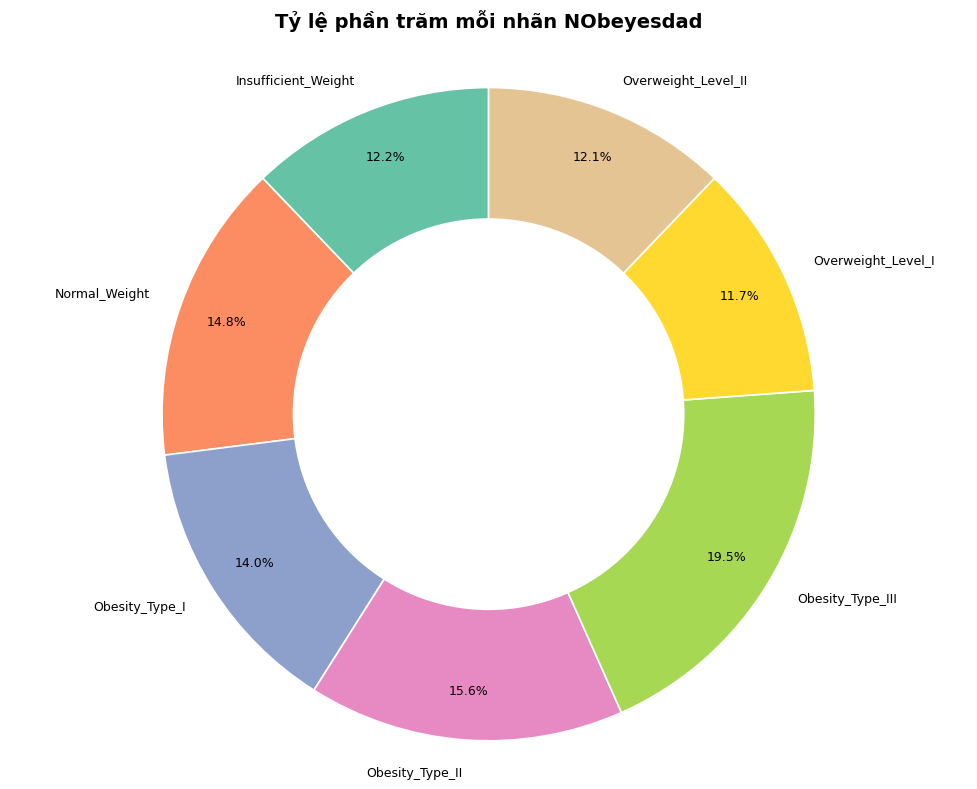

In [8]:
total_samples = len(df_clean)
percentage_per_label = (df_clean['NObeyesdad'].value_counts().sort_index() / total_samples) * 100

label_names = label_encoder_target.classes_

plt.figure(figsize=(10, 8))
colors = sns.color_palette("Set2", len(label_names))

wedges, texts, autotexts = plt.pie(
    percentage_per_label.values,
    labels=label_names,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    pctdistance=0.85,
    textprops={'fontsize': 9, 'color': 'black'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.2}
)

centre_circle = plt.Circle((0, 0), 0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.title("Tỷ lệ phần trăm mỗi nhãn NObeyesdad", fontsize=14, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()


## Phân bố tuổi, cân nặng và các yếu tố khác

### Phân bố các biến liên tục (Age, Height, Weight, FCVC, NCP, CH2O, FAF, TUE)

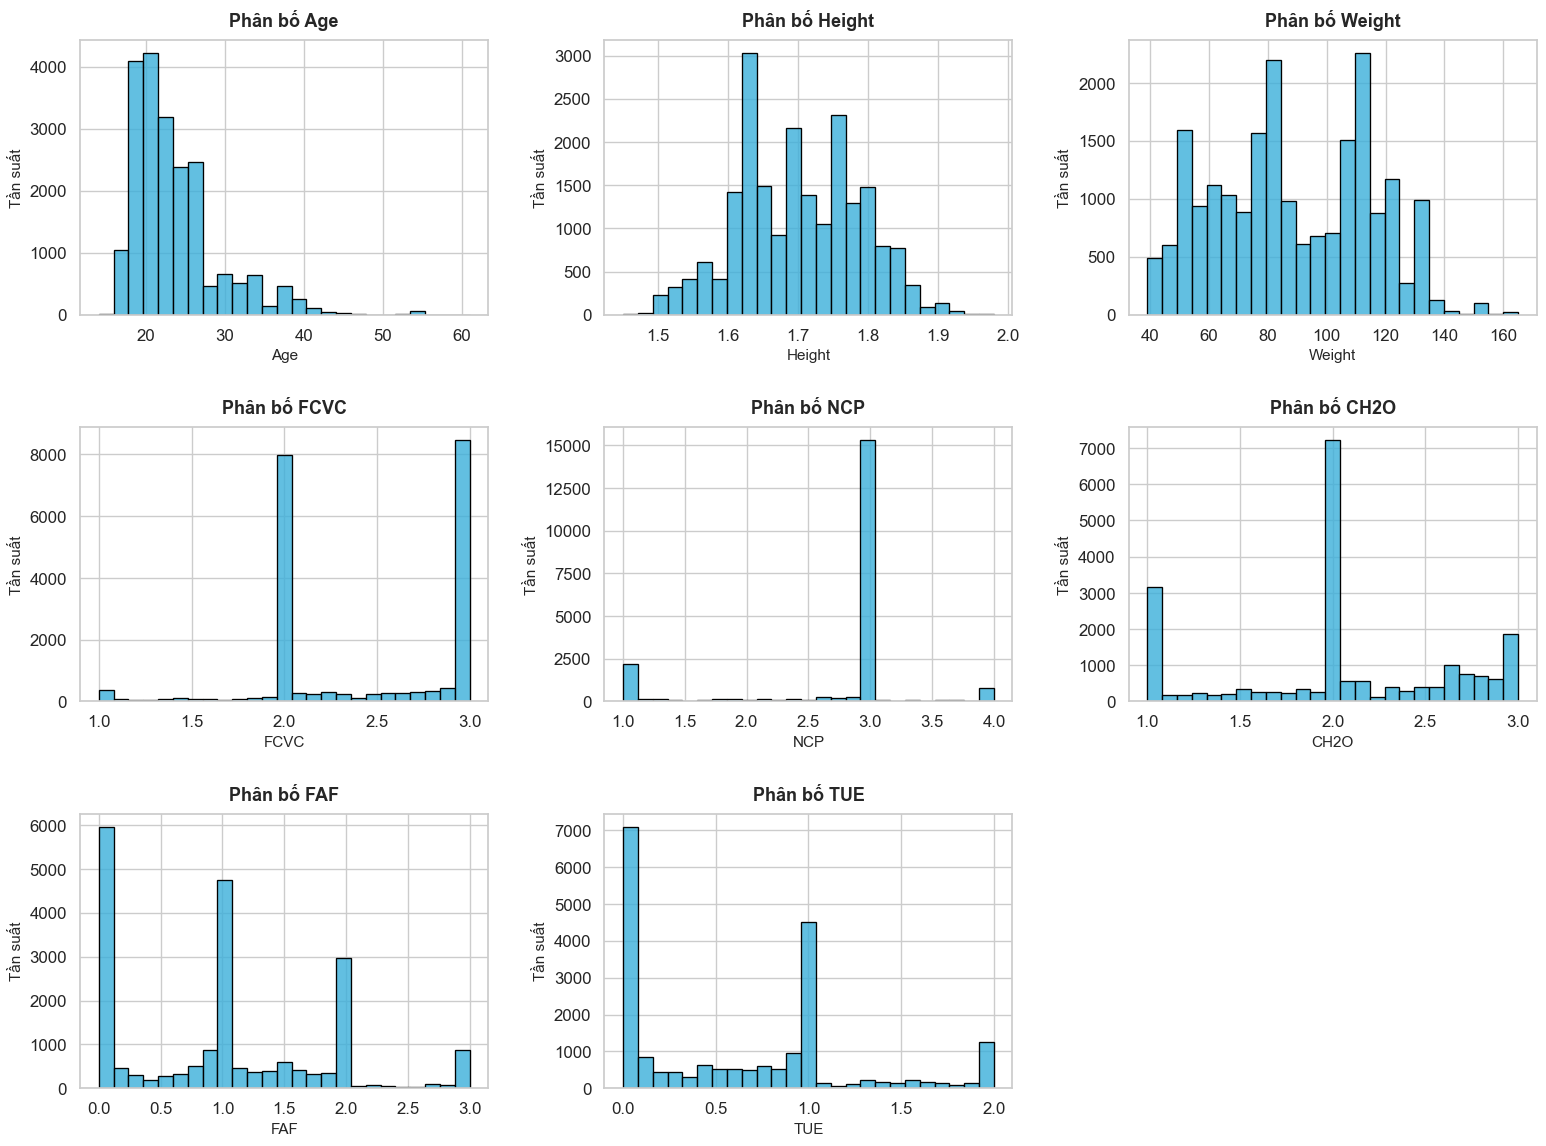

In [9]:
# Các biến liên tục
continuous_vars = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(16, 12))

for i, var in enumerate(continuous_vars, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_clean[var], bins=25, kde=False, color='#3BAFDA', edgecolor='black', alpha=0.8)
    plt.title(f'Phân bố {var}', fontsize=13, fontweight='bold', pad=10)
    plt.xlabel(var, fontsize=11)
    plt.ylabel('Tần suất', fontsize=11)

plt.subplot(3, 3, 9).axis('off')

plt.tight_layout(pad=2.0)
plt.show()

### Phân bố các biến category (Gender, CAEC, CALC, MTRANS, family_history, FAVC, SMOKE, SCC)

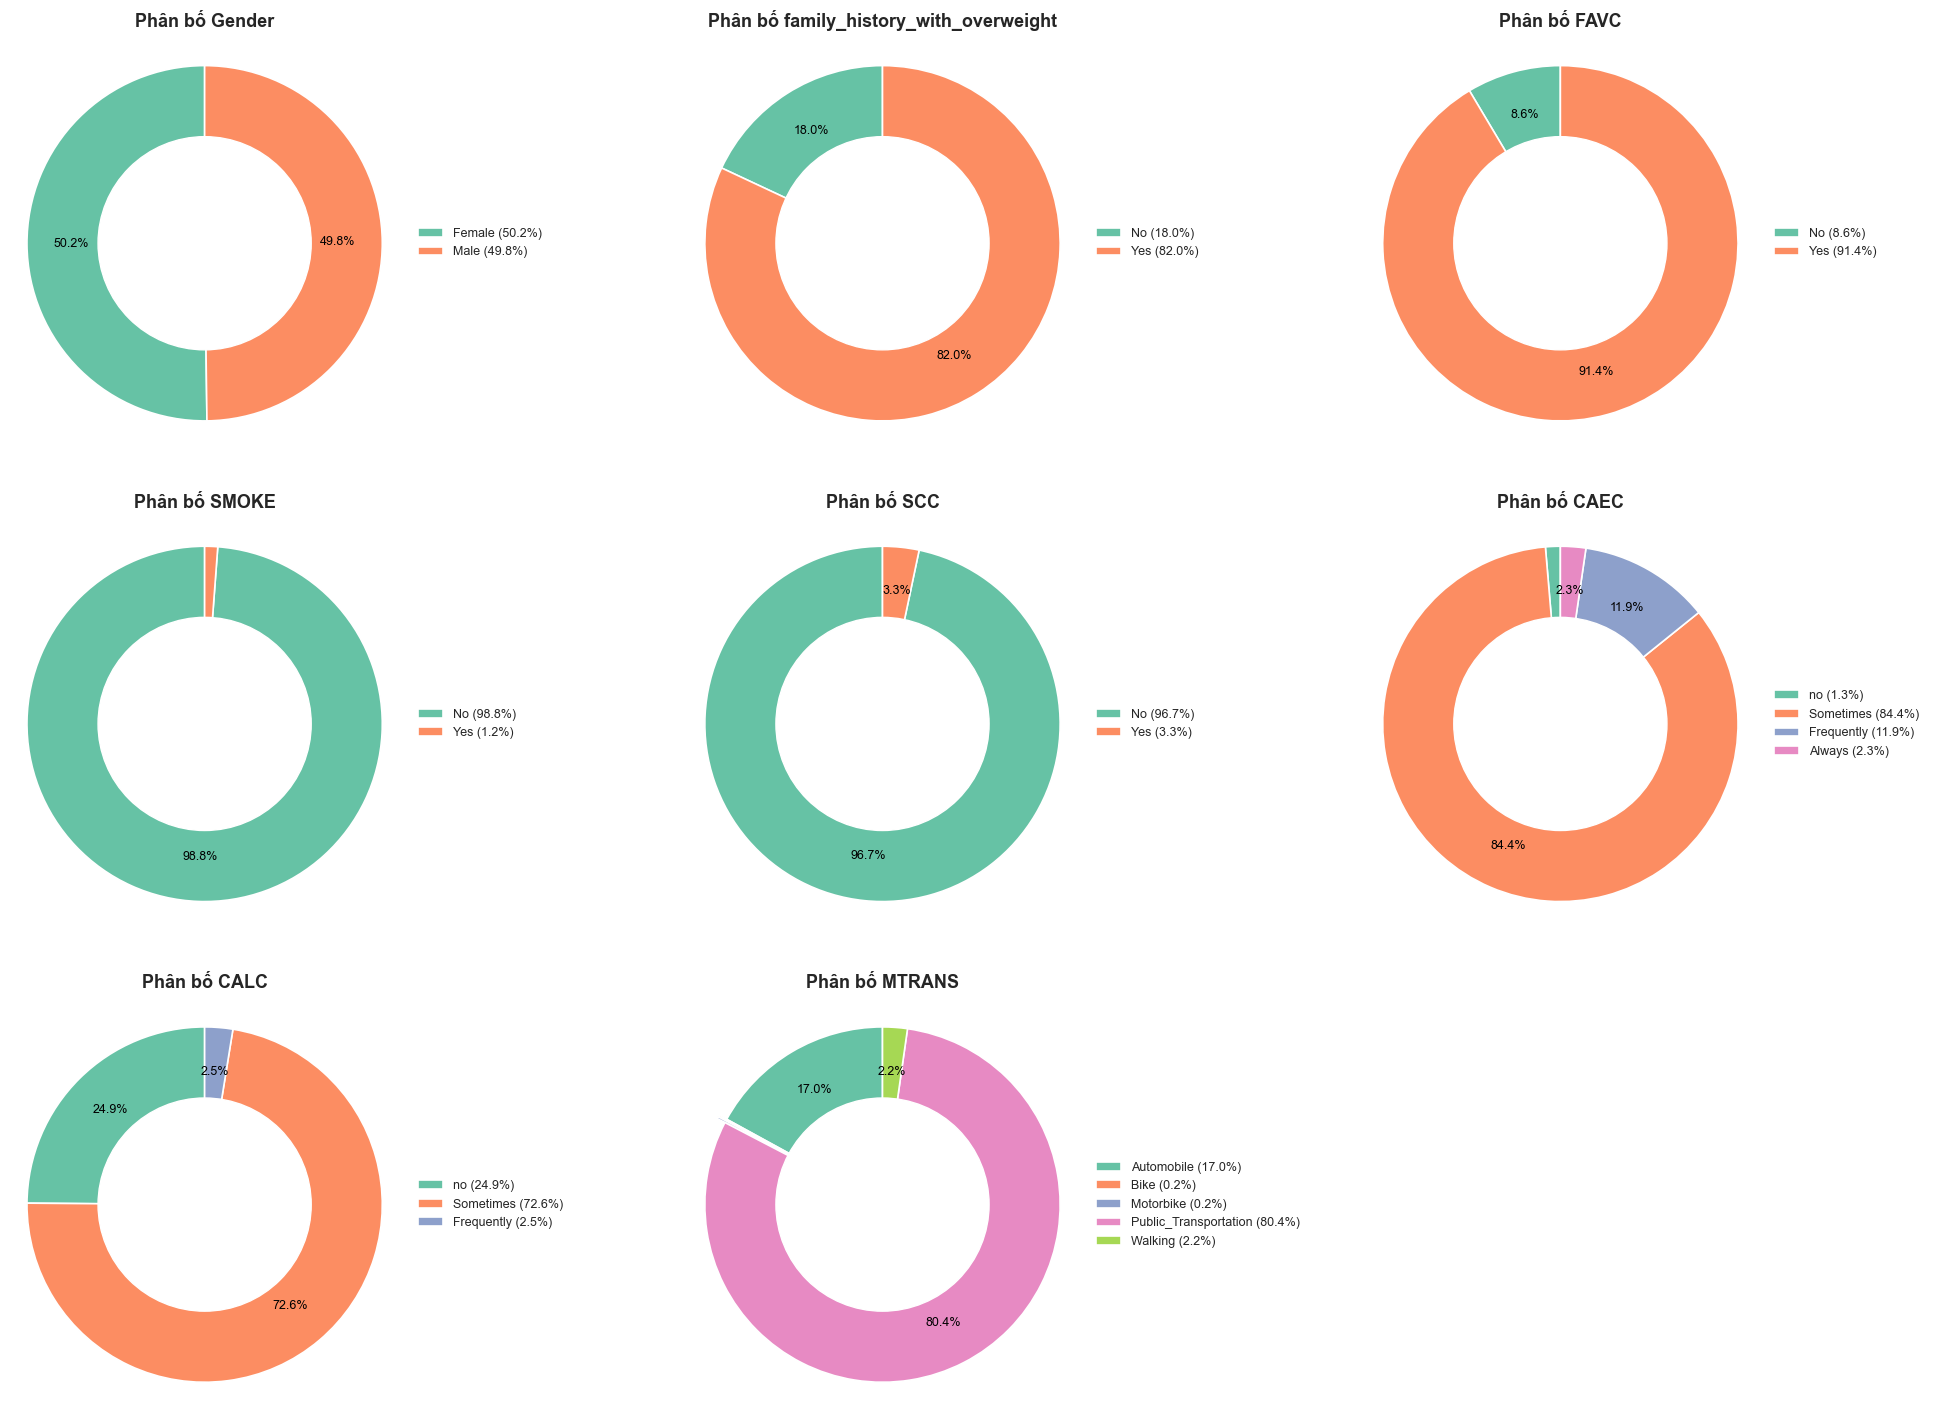

In [10]:
categorical_vars = {
    'Gender': {0: 'Female', 1: 'Male'},
    'family_history_with_overweight': {0: 'No', 1: 'Yes'},
    'FAVC': {0: 'No', 1: 'Yes'},
    'SMOKE': {0: 'No', 1: 'Yes'},
    'SCC': {0: 'No', 1: 'Yes'},
    'CAEC': {0: 'no', 1: 'Sometimes', 2: 'Frequently', 3: 'Always'},
    'CALC': {0: 'no', 1: 'Sometimes', 2: 'Frequently', 3: 'Always'}
}

fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

palette = sns.color_palette("Set2", 8)

for i, (var, mapping) in enumerate(categorical_vars.items()):
    counts = df_clean[var].value_counts().sort_index()
    labels = [mapping[idx] for idx in counts.index]

    percentages = counts.values / counts.sum() * 100
    explode = [0.05 if p < 1.0 else 0 for p in percentages]

    wedges, texts, autotexts = axes[i].pie(
        counts.values,
        labels=None,
        autopct=lambda p: f'{p:.1f}%' if p >= 2 else '',
        colors=palette,
        startangle=90,
        pctdistance=0.75,
        explode=explode,
        textprops={'fontsize': 9, 'color': 'black'},
        wedgeprops={'edgecolor': 'white', 'linewidth': 1.2}
    )

    centre_circle = plt.Circle((0, 0), 0.6, fc='white')
    axes[i].add_artist(centre_circle)
    axes[i].axis('equal')

    axes[i].set_title(f'Phân bố {var}', fontsize=13, fontweight='bold', pad=15)

    axes[i].legend(
        wedges,
        [f"{lbl} ({p:.1f}%)" for lbl, p in zip(labels, percentages)],
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        fontsize=9,
        frameon=False
    )

# Biểu đồ cho MTRANS (One-Hot Encoded)
mtrans_cols = [col for col in df_clean.columns if col.startswith('MTRANS_')]
mtrans_counts = df_clean[mtrans_cols].sum()
mtrans_labels = [col.replace('MTRANS_', '') for col in mtrans_cols]
mtrans_percentages = (mtrans_counts.values / len(df_clean)) * 100

explode_mtrans = [0.05 if p < 1.0 else 0 for p in mtrans_percentages]

wedges, texts, autotexts = axes[7].pie(
    mtrans_counts.values,
    labels=None,
    autopct=lambda p: f'{p:.1f}%' if p >= 2 else '',
    colors=palette,
    startangle=90,
    pctdistance=0.75,
    explode=explode_mtrans,
    textprops={'fontsize': 9, 'color': 'black'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.2}
)

centre_circle = plt.Circle((0, 0), 0.6, fc='white')
axes[7].add_artist(centre_circle)
axes[7].axis('equal')
axes[7].set_title('Phân bố MTRANS', fontsize=13, fontweight='bold', pad=15)

axes[7].legend(
    wedges,
    [f"{lbl} ({p:.1f}%)" for lbl, p in zip(mtrans_labels, mtrans_percentages)],
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    fontsize=9,
    frameon=False
)

axes[8].axis('off')

plt.tight_layout(pad=3.0)
plt.subplots_adjust(right=0.9)
plt.show()

# Tiền xử lý lần cuối

## Xóa các trường dữ liệu nhiễu

Dựa vào trựa quan hóa bên trên, 2 trường **SMOKE** và **SCC** đều có giá trị chiếm hơn 95% giá trị của cột. Nhóm quyết định xóa 2 cột này để loại bỏ nhiễu

In [11]:
df_clean = df_clean.drop(['SMOKE', 'SCC'], axis=1)

## Sắp xếp lại cột và lưu vào data

In [12]:
# Sắp xếp lại cột: đưa nhãn NObeyesdad xuống cuối
cols = [col for col in df_clean.columns if col != 'NObeyesdad']
cols.append('NObeyesdad')
df_clean = df_clean[cols]

df_clean.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,NObeyesdad
0,1,24.0,1.70,81.67,1,1,2.000000,2.983297,1,2.763573,0.000000,0.976473,1,0,0,0,1,0,6
1,0,18.0,1.56,57.00,1,1,2.000000,3.000000,2,2.000000,1.000000,1.000000,0,1,0,0,0,0,1
2,0,18.0,1.71,50.17,1,1,1.880534,1.411685,1,1.910378,0.866045,1.673584,0,0,0,0,1,0,0
3,0,20.0,1.71,131.27,1,1,3.000000,3.000000,1,1.674061,1.467863,0.780199,1,0,0,0,1,0,4
4,1,31.0,1.91,93.80,1,1,2.679664,1.971472,1,1.979848,1.967973,0.931721,1,0,0,0,1,0,6


In [13]:
df_clean.to_csv("data/obesity_data_cleaned.csv", index=False)